**Import the Libraries**

In [17]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

**Load the cleaned dataset from CSV**

In [23]:
data = pd.read_csv('cleaned_data.csv')
data['week'] = pd.to_datetime(data['week'])

 **SettingsTarget variable (log-transformed revenue)**

In [24]:
TARGET = 'log1p_revenue'
TIME_COL = 'week'

**Define channels/features**






In [25]:
SOCIALS = ['facebook_spend','tiktok_spend','instagram_spend','snapchat_spend']
SEARCH = ['google_spend']
ADSTOCK = [f'{s.split("_")[0]}_adstock' for s in SEARCH + SOCIALS]
EXTRA = ['log_price','average_price','promotions','followers','email_sent','sms_sent']

**Keep only the columns that exist in the data**

In [26]:
SOCIALS = [c for c in SOCIALS if c in data.columns]
SEARCH = [c for c in SEARCH if c in data.columns]
ADSTOCK = [c for c in ADSTOCK if c in data.columns]
EXTRA = [c for c in EXTRA if c in data.columns]

**Identify lagged features and Fourier/time features**

In [21]:
lag_cols = [c for c in data.columns if '_lag' in c and any(s in c for s in SOCIALS+SEARCH+['revenue'])]
fourier_cols = [c for c in data.columns if c.startswith('annual_')]
time_feats = [c for c in ['t','week_of_year','month','year'] if c in data.columns]

**Stage1 & Stage2 features**

In [27]:
stage1_features = SOCIALS + ADSTOCK + time_feats + fourier_cols + [c for c in EXTRA if c != 'average_price']
stage1_features = [c for c in stage1_features if c in data.columns]

stage2_features = SOCIALS + ADSTOCK + lag_cols + time_feats + fourier_cols + EXTRA
stage2_features = [c for c in stage2_features if c in data.columns]

print("Stage1 features:", stage1_features)
print("Stage2 features:", stage2_features)

Stage1 features: ['facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend', 'google_adstock', 'facebook_adstock', 'tiktok_adstock', 'instagram_adstock', 'snapchat_adstock', 't', 'week_of_year', 'month', 'year', 'annual_sin_1', 'annual_cos_1', 'annual_sin_2', 'annual_cos_2', 'annual_sin_3', 'annual_cos_3', 'log_price', 'promotions']
Stage2 features: ['facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend', 'google_adstock', 'facebook_adstock', 'tiktok_adstock', 'instagram_adstock', 'snapchat_adstock', 'facebook_spend_lag1', 'facebook_spend_lag2', 'facebook_spend_lag3', 'facebook_spend_lag4', 'tiktok_spend_lag1', 'tiktok_spend_lag2', 'tiktok_spend_lag3', 'tiktok_spend_lag4', 'instagram_spend_lag1', 'instagram_spend_lag2', 'instagram_spend_lag3', 'instagram_spend_lag4', 'snapchat_spend_lag1', 'snapchat_spend_lag2', 'snapchat_spend_lag3', 'snapchat_spend_lag4', 'google_spend_lag1', 'google_spend_lag2', 'google_spend_lag3', 'google_spend_lag4', 'revenue_lag1', 're

**Train/Test Split**

In [28]:
TEST_WEEKS = 12
train = data.iloc[:-TEST_WEEKS].copy()
test  = data.iloc[-TEST_WEEKS:].copy()

**Stage1: RidgeCV to predict Google spend**

In [29]:
if len(SEARCH) == 0:
    raise ValueError("No google_spend column found in data.")
google_col = SEARCH[0]

train_s1 = train.dropna(subset=stage1_features + [google_col])
X_s1 = train_s1[stage1_features]
y_s1 = train_s1[google_col]

tscv = TimeSeriesSplit(n_splits=5)
ridge_alphas = np.logspace(-3,3,25)
s1_model = make_pipeline(StandardScaler(), RidgeCV(alphas=ridge_alphas, cv=tscv))
s1_model.fit(X_s1, y_s1)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00000000e-03, 1.77827941e-03, 3.16227766e-03, 5.62341325e-03,
       1.00000000e-02, 1.77827941e-02, 3.16227766e-02, 5.62341325e-02,
       1.00000000e-01, 1.77827941e-01, 3.16227766e-01, 5.62341325e-01,
       1.00000000e+00, 1.77827941e+00, 3.16227766e+00, 5.62341325e+00,
       1.00000000e+01, 1.77827941e+01, 3.16227766e+01, 5.62341325e+01,
       1.00000000e+02, 1.77827941e+02, 3.16227766e+02, 5.62341325e+02,
       1.00000000e+03]),
                         cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)))])

**Predict Google spend for entire dataset**

In [30]:
data['google_pred'] = np.nan
mask_all = data[stage1_features].notna().all(axis=1)
data.loc[mask_all, 'google_pred'] = s1_model.predict(data.loc[mask_all, stage1_features])
data['google_pred'] = data['google_pred'].fillna(0)

**Add predicted Google to Stage2 features**

In [31]:
if 'google_pred' not in stage2_features:
    stage2_features = ['google_pred'] + [c for c in stage2_features if c != google_col]

**Stage2: ElasticNetCV to predict Revenue**

In [32]:
train_s2 = data.iloc[:-TEST_WEEKS].dropna(subset=stage2_features + [TARGET]).copy()
test_s2  = data.iloc[-TEST_WEEKS:].dropna(subset=stage2_features + [TARGET]).copy()

X_train = train_s2[stage2_features]
y_train = train_s2[TARGET]
X_test  = test_s2[stage2_features]
y_test  = test_s2[TARGET]

 **Evaluation function**

In [33]:
def eval_model(model, Xtr, ytr, Xte, yte):
    ytr_pred = model.predict(Xtr)
    yte_pred = model.predict(Xte)

    def metrics(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae  = mean_absolute_error(y_true, y_pred)
        r2   = r2_score(y_true, y_pred)
        return {'rmse': rmse, 'mae': mae, 'r2': r2}

    return metrics(ytr, ytr_pred), metrics(yte, yte_pred), yte_pred

**Fit Stage2 ElasticNet**

In [34]:
l1_ratio = [0.1,0.5,0.9]
enet = ElasticNetCV(l1_ratio=l1_ratio, n_alphas=50, cv=tscv, max_iter=5000)
pipe = make_pipeline(StandardScaler(), enet)
pipe.fit(X_train, y_train)

train_metrics, test_metrics, y_test_pred = eval_model(pipe, X_train, y_train, X_test, y_test)
print("Train metrics:", train_metrics)
print("Test metrics:", test_metrics)

Train metrics: {'rmse': np.float64(0.5879919362389431), 'mae': 0.44752788966119045, 'r2': 0.6712513241578623}
Test metrics: {'rmse': np.float64(0.43689034319420234), 'mae': 0.3959847453028196, 'r2': 0.686892037538332}




 **Diagnostics**


In [35]:
coef = pipe.named_steps['elasticnetcv'].coef_
coef_df = pd.DataFrame({'feature': stage2_features, 'coef': coef}).sort_values('coef', key=lambda s: s.abs(), ascending=False)
print("\nTop coefficients:")
print(coef_df.head(20))


Top coefficients:
                feature      coef
3       instagram_spend  0.549760
45        average_price -0.193266
30         revenue_lag1  0.157610
44            log_price -0.150626
43         annual_cos_3  0.107064
34                    t  0.028624
42         annual_sin_3 -0.025387
17    tiktok_spend_lag4 -0.017983
40         annual_sin_2 -0.016553
38         annual_sin_1  0.014586
1        facebook_spend -0.000000
2          tiktok_spend -0.000000
4        snapchat_spend  0.000000
5        google_adstock -0.000000
0           google_pred -0.000000
14    tiktok_spend_lag1  0.000000
13  facebook_spend_lag4  0.000000
12  facebook_spend_lag3  0.000000
11  facebook_spend_lag2 -0.000000
10  facebook_spend_lag1  0.000000


**Residual plot**

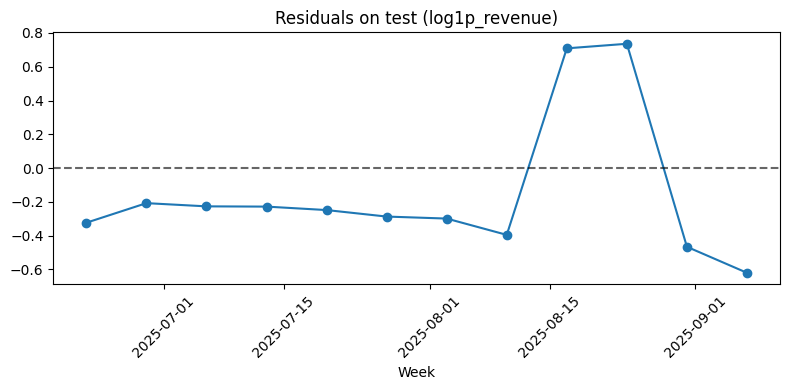

In [36]:
resid = y_test - y_test_pred
plt.figure(figsize=(8,4))
plt.plot(test_s2[TIME_COL], resid, marker='o')
plt.axhline(0, color='k', linestyle='--', alpha=0.6)
plt.title('Residuals on test (log1p_revenue)')
plt.xlabel('Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Google predicted vs actual**

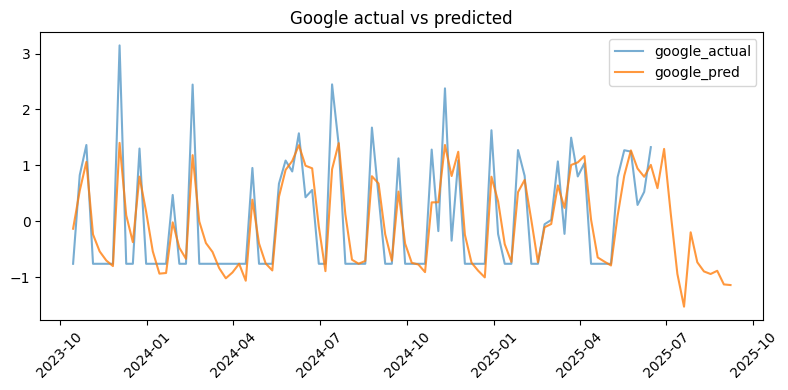

In [37]:
plt.figure(figsize=(8,4))
plt.plot(train[TIME_COL], train[google_col], label='google_actual', alpha=0.6)
plt.plot(data[TIME_COL], data['google_pred'], label='google_pred', alpha=0.8)
plt.legend()
plt.title('Google actual vs predicted')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**RandomForest check**

In [38]:
rf = RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42)
rf_pipe = make_pipeline(StandardScaler(), rf)
rf_pipe.fit(X_train, y_train)
_, rf_test_metrics, _ = eval_model(rf_pipe, X_train, y_train, X_test, y_test)
print("\nRandomForest test metrics:", rf_test_metrics)

importances = rf_pipe.named_steps['randomforestregressor'].feature_importances_
fi = pd.DataFrame({'feature': stage2_features, 'importance': importances}).sort_values('importance', ascending=False)
print("\nRF top features:")
print(fi.head(15))


RandomForest test metrics: {'rmse': np.float64(0.20605798404015316), 'mae': 0.15503662816093536, 'r2': 0.9303488783723393}

RF top features:
                feature  importance
3       instagram_spend    0.290927
30         revenue_lag1    0.148131
45        average_price    0.107003
44            log_price    0.097259
35         week_of_year    0.078587
8     instagram_adstock    0.068472
40         annual_sin_2    0.049189
31         revenue_lag2    0.016325
13  facebook_spend_lag4    0.011030
22  snapchat_spend_lag1    0.010686
39         annual_cos_1    0.009105
6      facebook_adstock    0.008087
38         annual_sin_1    0.007354
12  facebook_spend_lag3    0.006003
34                    t    0.005796


***Save models***

In [39]:
joblib.dump(s1_model, 'stage1_google_model.pkl')
joblib.dump(pipe, 'stage2_revenue_model.pkl')

['stage2_revenue_model.pkl']

In [40]:
print("\nNotes:")
print("- Stage1: Ridge predicts Google spend (mediator).")
print("- Stage2: ElasticNet predicts revenue using predicted Google + socials + adstock + lags + controls.")
print("- TimeSeriesSplit avoids look-ahead in CV.")
print("- Coefficients are interpretable in log-space (elasticities).")


Notes:
- Stage1: Ridge predicts Google spend (mediator).
- Stage2: ElasticNet predicts revenue using predicted Google + socials + adstock + lags + controls.
- TimeSeriesSplit avoids look-ahead in CV.
- Coefficients are interpretable in log-space (elasticities).
